In [1]:
!uv pip install jupyterlab-vim

Sourcing .zshenv...
Using Python 3.12.10 environment at: /home/flynn/repos/work/mbo_utilities/.venv
Resolved 92 packages in 134ms                                        
Installed 1 package in 5ms.4                                
 + jupyterlab-vim==4.1.4


In [9]:
%load_ext autoreload
%autoreload 2

import mbo_utilities as mbo
import fastplotlib as fpl
import numpy as np
from pathlib import Path

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
fname_scan = [x for x in Path(r"/home/flynn/lbm_data/raw").glob("*tif*")]
raw_scan = mbo.read_scan(fname_scan)

Initializing MBO Scan with parameters:
roi: None, fix_phase: True, phasecorr_method: frame, border: 3, upsample: 1, max_offset: 4


Raw tiff fully read.


In [3]:
raw_scan = mbo.lazy_array.imread("/home/flynn/lbm_data/raw")

Initializing MBO Scan with parameters:
roi: None, fix_phase: True, phasecorr_method: frame, border: 3, upsample: 5, max_offset: 4


Generating combined kerchunk reference for 2 files…
Combined kerchunk reference written to /home/flynn/lbm_data/raw/combined_refs.json
Raw tiff fully read.


In [10]:
import os

os.environ["MBO_DEBUG"] = "1"

In [11]:
raw_scan.fix_phase = False
raw_scan.roi = 0

In [12]:
type(raw_scan)

mbo_utilities.lazy_array.MBOScanArray

In [8]:
%%timeit
raw_scan[:200, 0, :, :]

3.72 s ± 345 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
raw_scan.data.fix_phase = False

In [14]:
%%timeit
raw_scan[:200, 0, :, :]

52.9 ms ± 845 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
%%timeit
raw_scan.fix_phase=False
raw_scan[:200, 0, :, :]

67 ms ± 1.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
%%timeit
raw_scan.fix_phase=False
raw_scan[:2000, 0, :, :]

76.4 ms ± 1.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
%%timeit
raw_scan.fix_phase=False
raw_scan[::5, 0, :, :]

11.7 ms ± 167 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
%%timeit
raw_scan.fix_phase=False
raw_scan.roi=0
raw_scan[::5, 0, :, :]

11.7 ms ± 38 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
zstore = raw_scan.as_zarr()

AttributeError: 'Scan_MBO' object has no attribute 'as_zarr'

## Raw vs Kerchunked

In [15]:
import tifffile

In [17]:
files = [x for x in Path("/home/flynn/lbm_data/raw/").glob("*.tif*")]
files

[PosixPath('/home/flynn/lbm_data/raw/mk301_03_01_2025_2roi_17p07hz_224x448px_2umpx_180mw_green_00002.tif'),
 PosixPath('/home/flynn/lbm_data/raw/mk301_03_01_2025_2roi_17p07hz_224x448px_2umpx_180mw_green_00001.tif')]

In [23]:
data = np.concat([tifffile.imread(files[i]) for i in range(len(files))], axis=0)
data.shape

(220, 14, 912, 224)

In [27]:
# /// script
# requires-python = ">=3.13"
# dependencies = [
#     "numpy",
#     "mbo_utilities",
#     "fastplotlib",
# ]
#
# [tool.uv.sources]
# mbo_utilities = { git = "https://github.com/MillerBrainObservatory/mbo_utilities", branch = "dev" }

%load_ext autoreload
%autoreload 2
import time
from functools import partial
from typing import Literal

import tifffile
from pathlib import Path
import tifffile as tiff
import numpy as np

import fastplotlib as fpl
from fastplotlib.ui import EdgeWindow
from fastplotlib.widgets import ImageWidget
from scipy.ndimage import fourier_shift

from mbo_utilities.lazy_array import imread, imwrite
import mbo_utilities as mbo
from mbo_utilities import is_raw_scanimage
from mbo_utilities.graphics._imgui import ndim_to_frame
from mbo_utilities.metadata import has_mbo_metadata

from imgui_bundle import imgui

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
def find_si_rois(file):
    """
    Find the ROIs in the current ScanImage session.

    Returns
    -------
    list
        List of ROI names.
    """
    with tifffile.TiffFile(file, mode="r") as _tf:
        if is_raw_scanimage(file):
            si_metadata = _tf.scanimage_metadata
        if has_mbo_metadata(file):
            si_metadata = _tf.shaped_metadata[0]["si"]
        rois = si_metadata["RoiGroups"]["imagingRoiGroup"]["rois"]
    return rois


def write_u16(infile: str | Path, outfile: str | Path):
    img = tiff.imread(infile).astype(np.int32)
    off  = img.min()
    rng  = img.max() - off
    u16  = (img - off).astype(np.uint16)

    tiff.imwrite(
        outfile,
        u16,
        photometric="minisblack",
        bitspersample=16,
        extratags=[
            (340, "H", 1, (0,),   False),
            (341, "H", 1, (rng if rng < 65536 else 65535,), False),
            (65535, "d", 2, (float(off), float(rng)), False)
        ],
    )

def timeit(func):
    """
    Decorator to time a function.
    """
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print(f"Function {func.__name__} took {end - start:.4f} seconds")
        return result
    return wrapper

import matplotlib.pyplot as plt
Path("/tmp/01").mkdir(exist_ok=True,)

data = imread(
    r"/home/flynn/lbm_data/raw"
)

Initializing MBO Scan with parameters:
roi: None, fix_phase: False, phasecorr_method: frame, border: 3, upsample: 4, max_offset: 3


Generating combined kerchunk reference for 2 files…
Combined kerchunk reference written to /home/flynn/lbm_data/raw/combined_refs.json
Raw tiff fully read.


In [29]:
data.output_xslices, data.output_yslices, data.xslices, data.yslices

([slice(0, 224, None), slice(224, 448, None)],
 [slice(0, 448, None), slice(0, 448, None)],
 [slice(0, 224, None), slice(0, 224, None)],
 [slice(0, 448, None), slice(464, 912, None)])

In [35]:
data.output_xslices[0], data.output_xslices[1]

(slice(0, 224, None), slice(224, 448, None))

In [45]:
data.fix_phase = True

RFBOutputContext()

JupyterRenderCanvas(css_height='550.0px', css_width='550.0px')
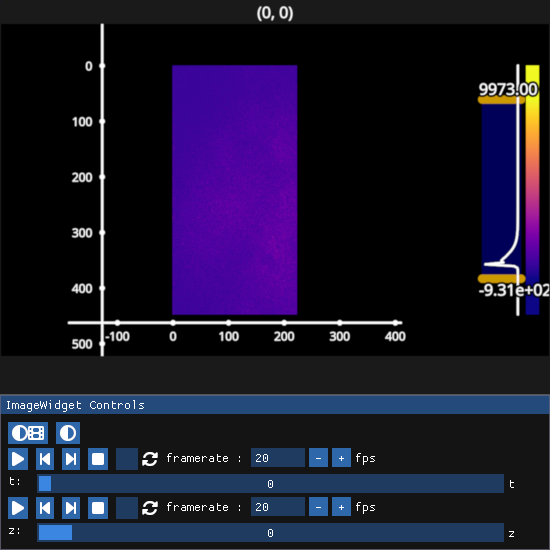

In [55]:
iw = fpl.ImageWidget(data, figure_kwargs={"size": (550, 550)})
iw.show()

In [26]:
zarray = mbo.file_io.ZarrScanView(
    data.data.as_zarr(),
    ys=data.yslices,
    xs=data.xslices,
    oys=data.output_yslices,
    oxs=data.output_xslices,
    roi=None,
)


TypeError: `data` must be an array-like type or a list of array-like.You have passed the following type <class 'mbo_utilities.file_io.ZarrScanView'>

In [5]:
iw.close()

In [ ]:
zarray = mbo.file_io.ZarrScanView(
    data.data.as_zarr(),
    yslices=data.yslices,
    xslices=data.xslices,
    roi=0,
)

In [15]:
zarray.shape, zarray[0, 0, ...].shape

self has no roi


((238, 14, 912, 224), (1, 1, 896, 224))

In [ ]:
files = [x for x in Path("/tmp/01/fsspec").glob("*.tif*")]
check = tifffile.imread(files[0])
fpl.ImageWidget(check,
                histogram_widget=True,
                figure_kwargs={"size": (800, 1000),},
                graphic_kwargs={"vmin": check.min(), "vmax": check.max()},
                window_funcs={"t": (np.mean, 0)},
               ).show()